In [2]:
# Import basic packages lik numpy, pandas, math plot and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_profiling as pr
from sklearn.preprocessing import LabelEncoder

from datetime import datetime
import lightgbm as lgbm
import warnings
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

warnings.filterwarnings('ignore') #ignore warning messages 

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score

%config InlineBackend.figure_formats = ['retina']
import time
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

import plotly.graph_objs as go
import plotly.subplots as tls
import plotly.offline as py

In [3]:
# import dataset
df = pd.read_csv('https://raw.githubusercontent.com/lijjumathew/MSDS-Machine-Learning-1-Project/master/dataset/Telco-Customer-Churn.csv')
df.sample(5).T

506                      6145            3462  \
customerID            8981-FJGLA               5010-IPEAQ      3834-XUIFC   
gender                      Male                   Female            Male   
SeniorCitizen                  0                        0               0   
Partner                       No                      Yes              No   
Dependents                   Yes                      Yes              No   
tenure                        11                       67               7   
PhoneService                 Yes                       No             Yes   
MultipleLines                Yes         No phone service             Yes   
InternetService      Fiber optic                      DSL     Fiber optic   
OnlineSecurity                No                      Yes              No   
OnlineBackup                  No                      Yes              No   
DeviceProtection             Yes                      Yes              No   
TechSupport                   No                      Yes              No   
StreamingTV                   No                      Yes              No   
StreamingMovies               No                       No             Yes   
Contract          Month-to-month                 Two year  Month-to-month   
PaperlessBilling             Yes                       No             Yes   
PaymentMethod       Mailed check  Credit card (automatic)    Mailed check   
MonthlyCharges                78                     54.2            85.2   
TotalCharges               851.8                  3623.95          602.55   
Churn                         No                       No             Yes   

                              3803                     4134  
customerID              2533-QVMSK               3005-TYFRD  
gender                        Male                   Female  
SeniorCitizen                    0                        0  
Partner                        Yes                      Yes  
Dependents                      No                       No  
tenure                          61                       55  
PhoneService                   Yes                      Yes  
MultipleLines                  Yes                      Yes  
InternetService        Fiber optic              Fiber optic  
OnlineSecurity                  No                       No  
OnlineBackup                   Yes                      Yes  
DeviceProtection                No                      Yes  
TechSupport                    Yes                       No  
StreamingTV                    Yes                      Yes  
StreamingMovies                 No                      Yes  
Contract                  Two year           Month-to-month  
PaperlessBilling               Yes                      Yes  
PaymentMethod     Electronic check  Credit card (automatic)  
MonthlyCharges                94.1                   103.65  
TotalCharges                5638.3                  5676.65  
Churn                          Yes                       No

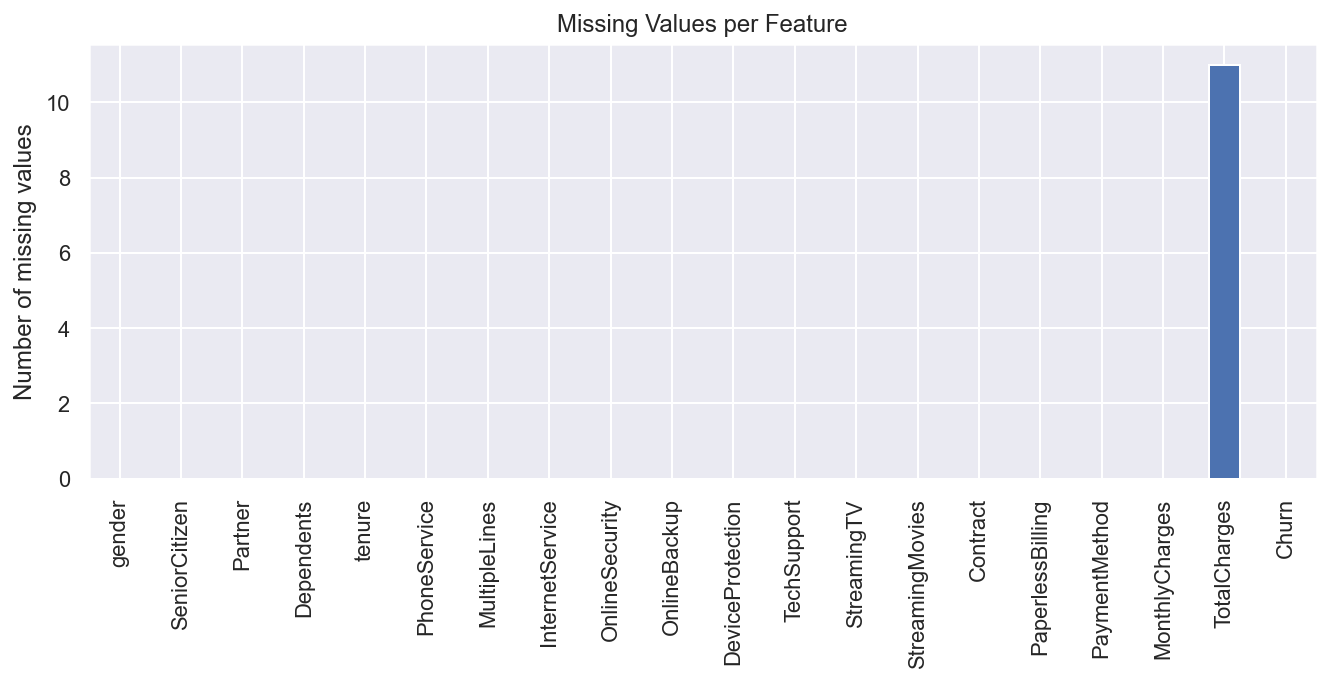

In [4]:
#Separating churn and non churn customers 
churn     = df[df["Churn"] == "Yes"]
not_churn = df[df["Churn"] == "No"]

Id     = ['customerID']
target = ["Churn"]

#Ideally SeniorCitizen column should be a factor, so let's convert 1,0 values to Yes,No and later we can label encode all factor columns
df.SeniorCitizen=df.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')

# Getting rid of unwanted columns like Customer Id.
if 'customerID' in df:
    del df['customerID']
    
# converting TotalCharges object dataset into numeric
# errors = 'coerce’ means, if invalid parsing occur then set NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = 'coerce')

# Replacing blank values with nulls.
df=df.replace(r'^\s*$', np.nan, regex=True)
# Total charges has some blank values/missing values and needs to be imputed. Filling the missing values

#the amount of missing values per feature
sns.set(rc={'figure.figsize':(11,4)})
pd.isnull(df).sum().plot(kind='bar')
plt.ylabel('Number of missing values')
plt.title('Missing Values per Feature');

df["TotalCharges"].fillna(df["TotalCharges"].mean(), inplace=True)

In [5]:
print(df.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Text(0.5, 1.0, 'Churn Percentage')

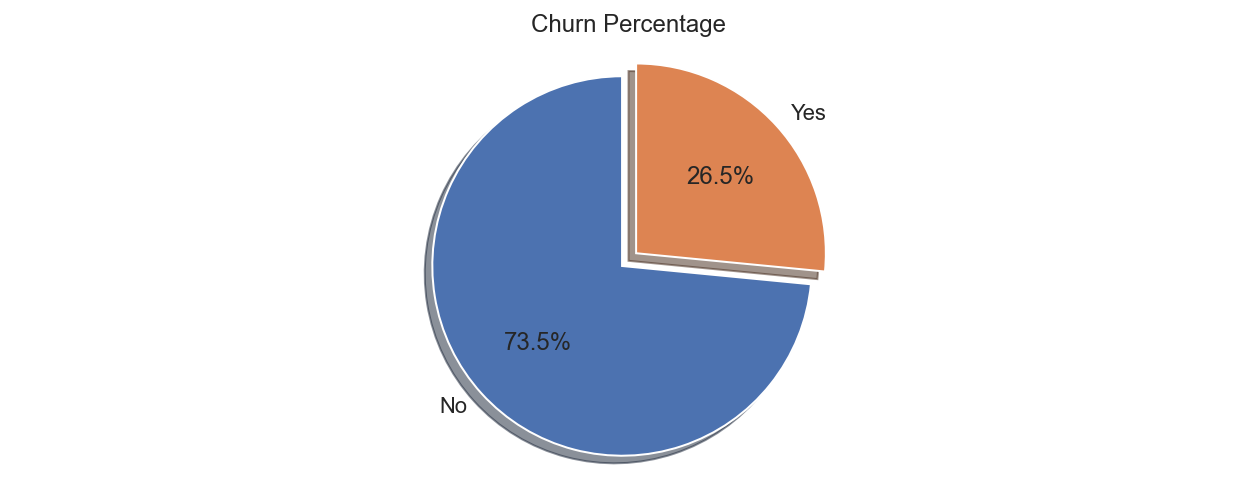

In [6]:
plt.pie(df["Churn"].value_counts(),explode=(0,0.1), autopct='%1.1f%%',shadow=True, startangle=90,labels=df["Churn"].unique())
plt.axis('equal') ;
plt.title('Churn Percentage')

In [7]:
df.describe()

tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2283.300441
std      24.559481       30.090047   2265.000258
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    402.225000
50%      29.000000       70.350000   1400.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000

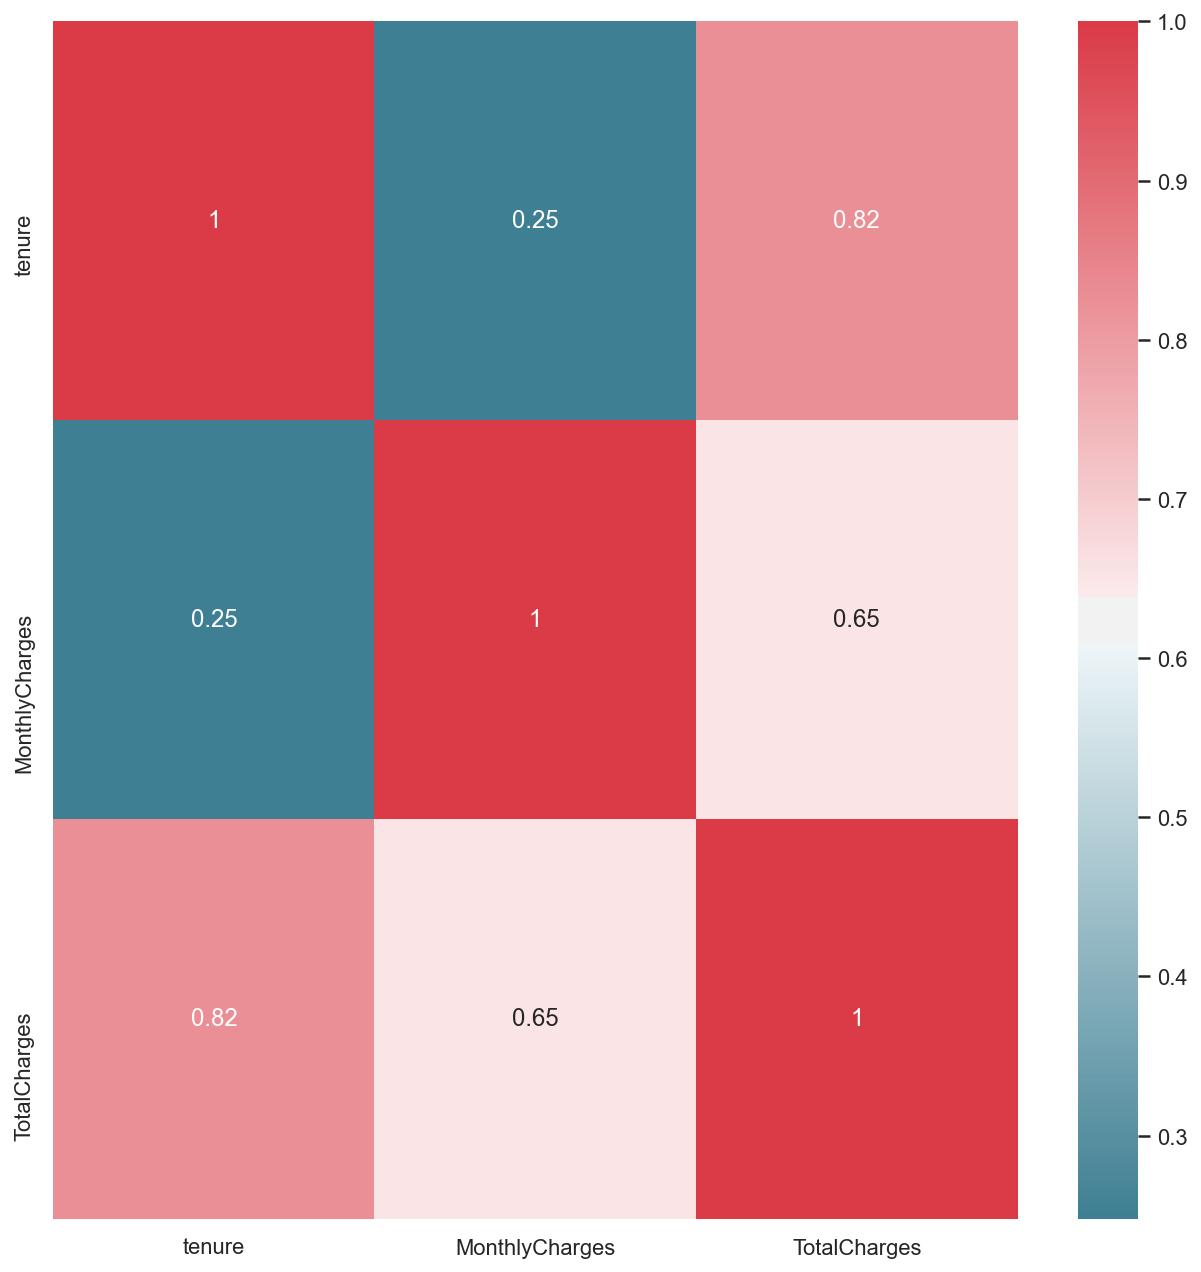

In [8]:
# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df.corr(), cmap=cmap, annot=True)
f.tight_layout()
#Tenure and TotalCharges, Monthly and TotalCharges are corelated and it makes sense,as totalcharges = tenure*MonthlyCharges

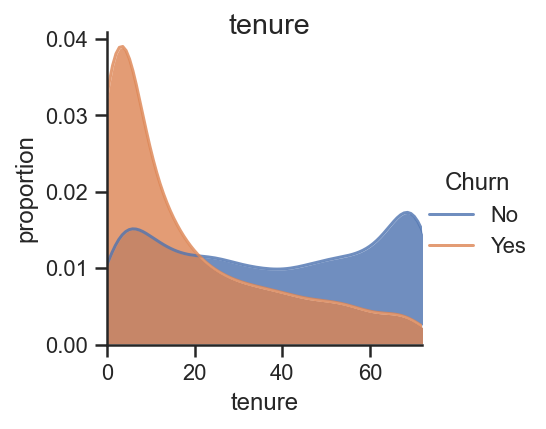

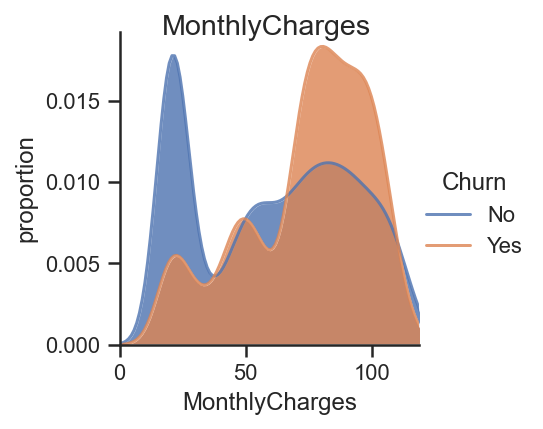

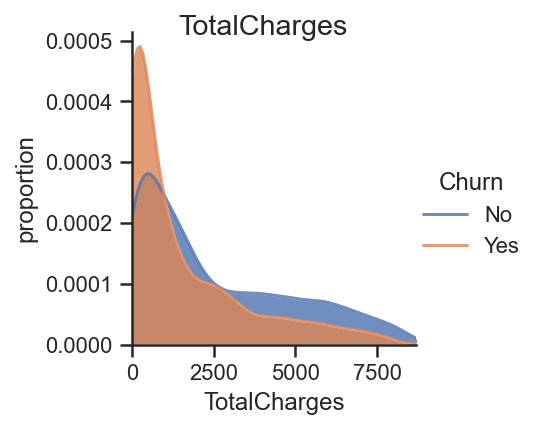

In [9]:
def plot_distribution_num(df_num):
    sns.set_style('ticks')
    s = sns.FacetGrid(df,hue='Churn')
    s.map(sns.kdeplot,df_num,shade = True, alpha = 0.8)
    s.set(xlim=(0,df[df_num].max()))
    s.add_legend()
    s.set_axis_labels(df_num,'proportion')
    s.fig.suptitle(df_num)
    plt.show()
    
plot_distribution_num('tenure')
plot_distribution_num('MonthlyCharges')
plot_distribution_num('TotalCharges')  

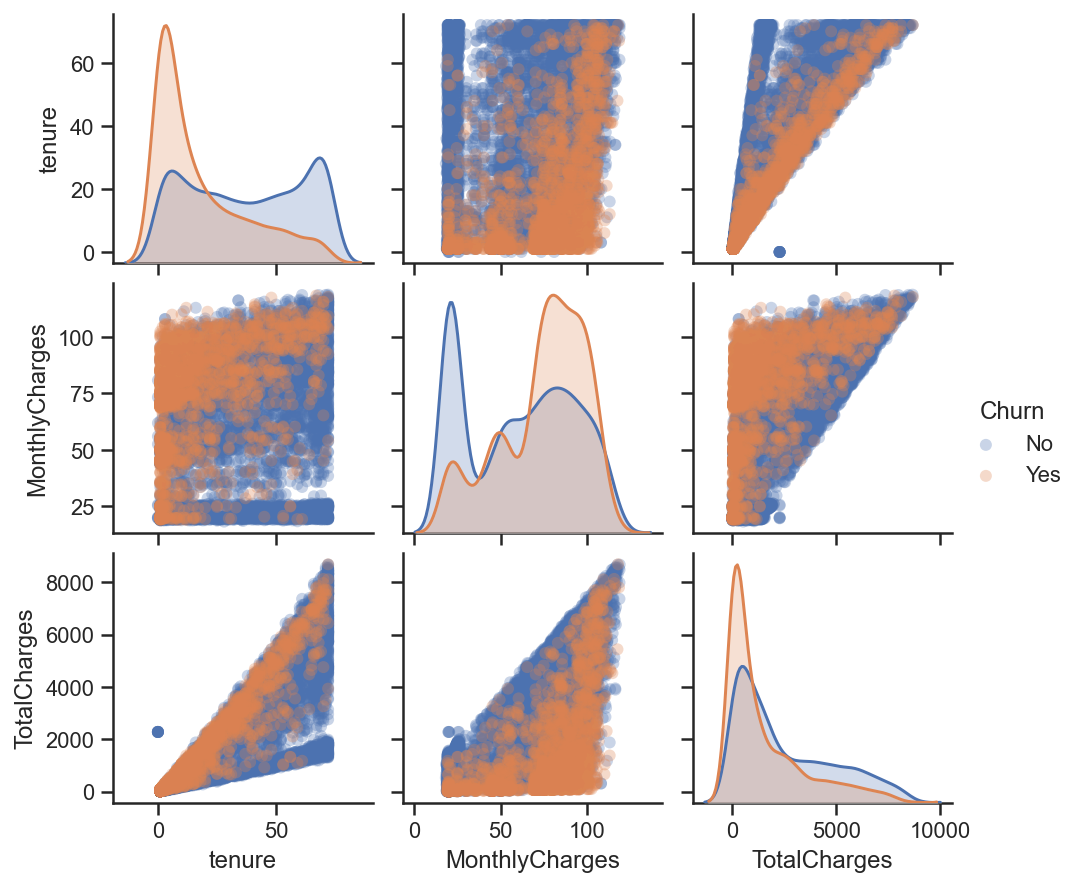

In [10]:
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], 
             hue='Churn', plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1)

In [11]:
# Tenure in months as year range
df['tenure_range'] = pd.cut(df.tenure,[0,12,24,36,48,60,72,84],3,
                            labels=['1 year','2 year','3 year', ' 4 year', '5 year', '6 year', '7 year'])

# change MonthlyCharges to categorical column 
def monthlycharges_split(df) : 
 if df['MonthlyCharges'] <= 30 :
     return '0–30'
 elif (df['MonthlyCharges'] > 30) & (df['MonthlyCharges'] <= 70 ):
     return '30–70'
 elif (df['MonthlyCharges'] > 70) & (df['MonthlyCharges'] <= 99 ):
     return '70–99'
 elif df['MonthlyCharges'] > 99 :
     return '99plus'
df['monthlycharges_bin'] = df.apply(lambda df:monthlycharges_split(df), axis = 1)

Text(0.5, 1.0, 'Churn by Tenure')

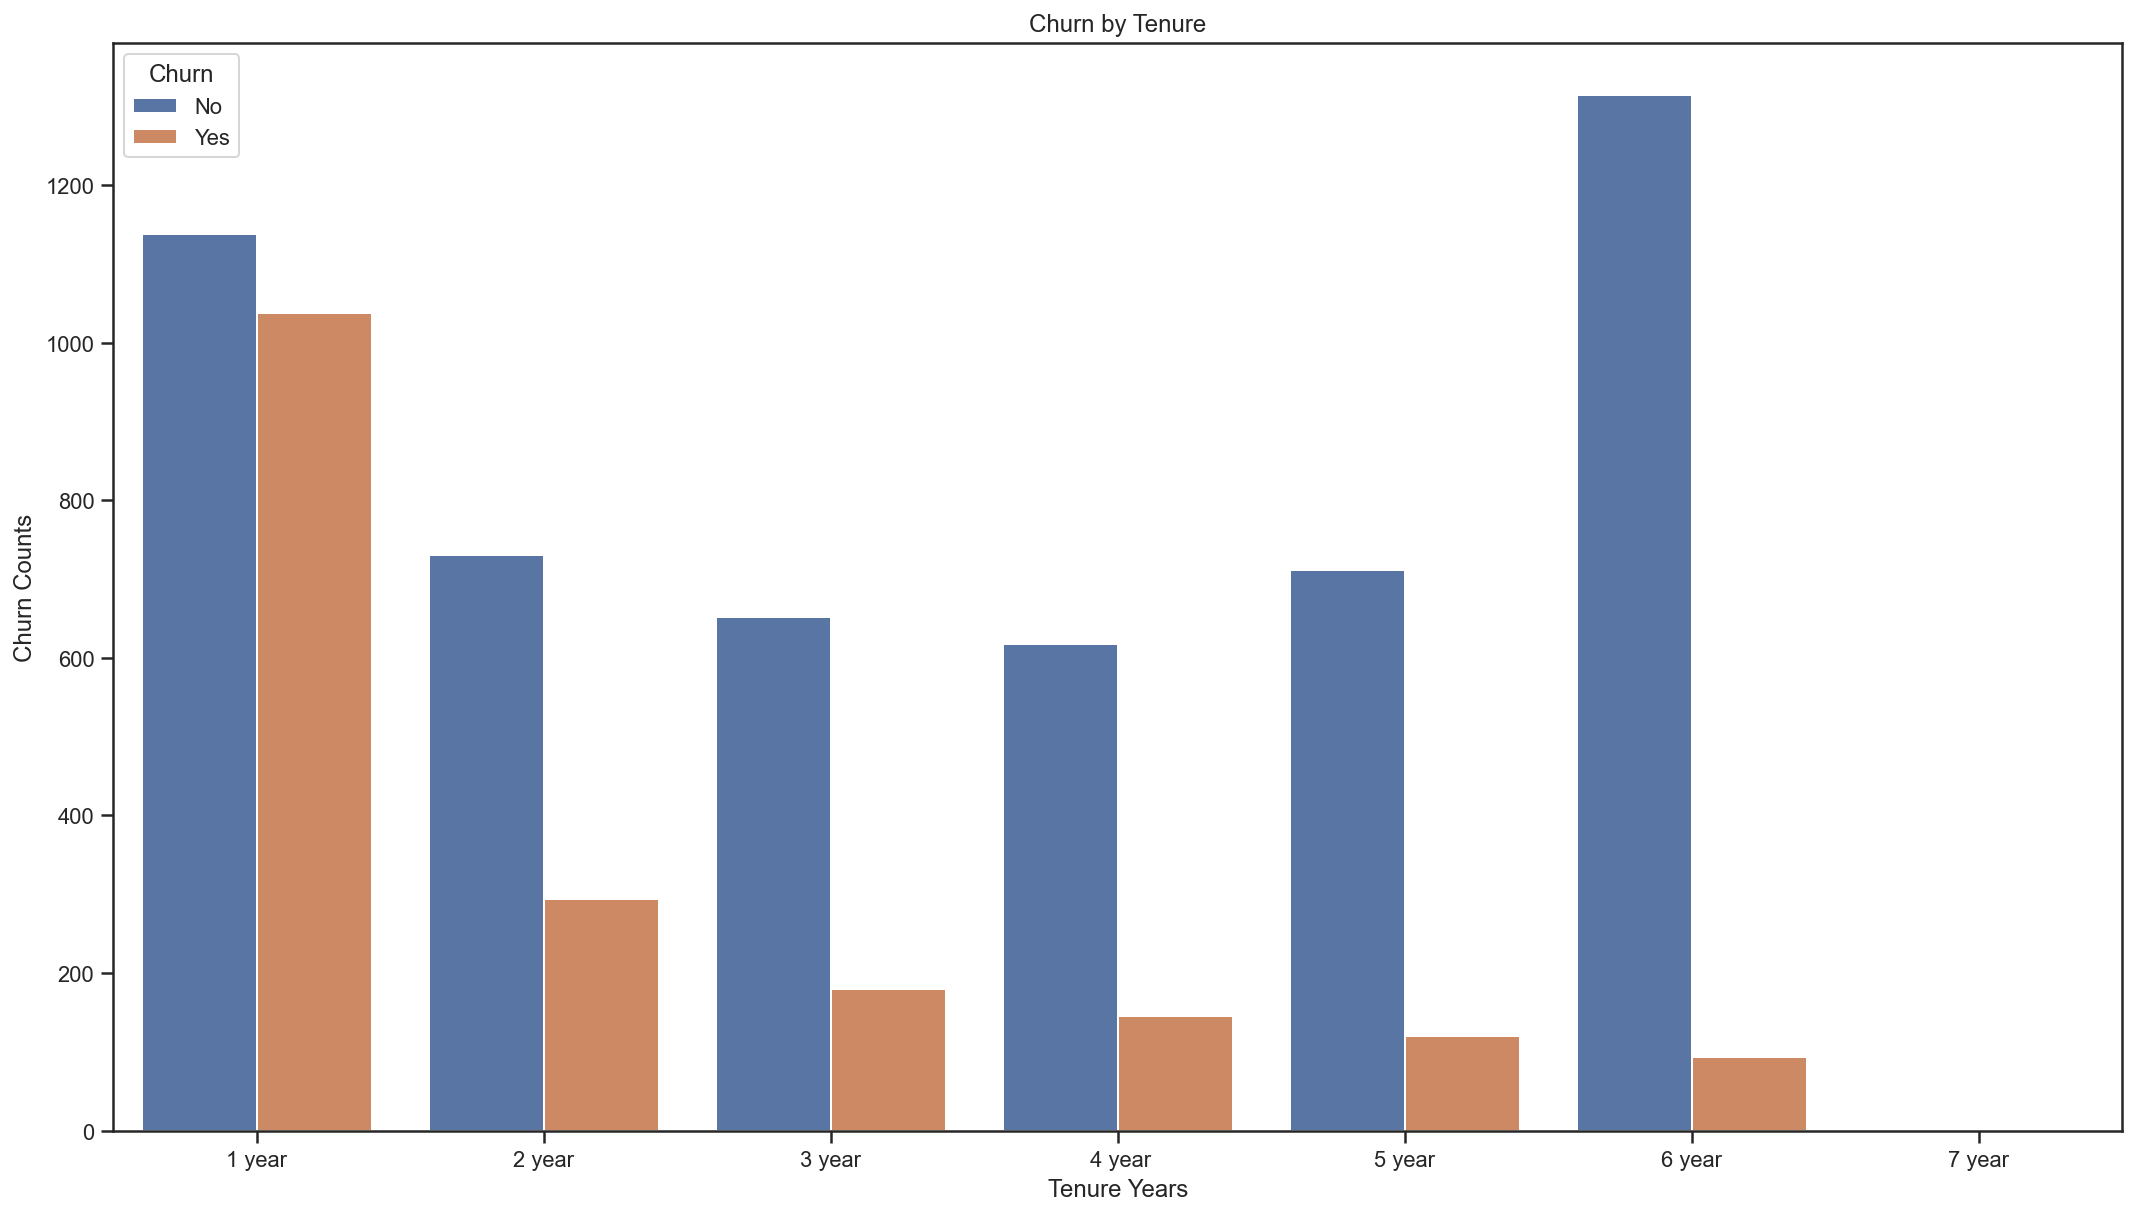

In [12]:
f, axes = plt.subplots(figsize=(18, 10))
sns.countplot(df["tenure_range"],hue = df["Churn"]);
plt.xlabel('Tenure Years')
plt.ylabel('Churn Counts')
plt.title('Churn by Tenure')

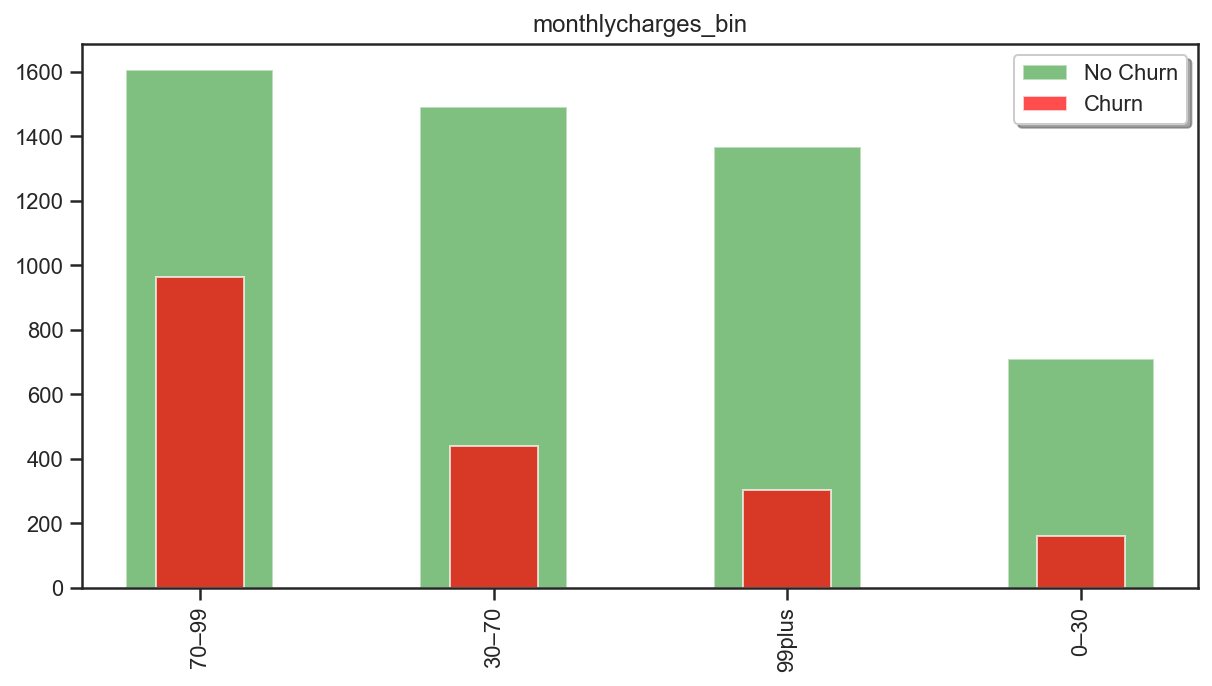

In [13]:
# new features monthlycharges_bin
plt.figure(figsize = [10,5])
df[df.Churn == "No"]['monthlycharges_bin'].value_counts().plot(kind = 'bar', color="green", alpha=0.5).set_title('monthlycharges_bin')
df[df.Churn == "Yes"]['monthlycharges_bin'].value_counts().plot(kind = 'bar', color="red", alpha=0.7, width=0.3)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=1)

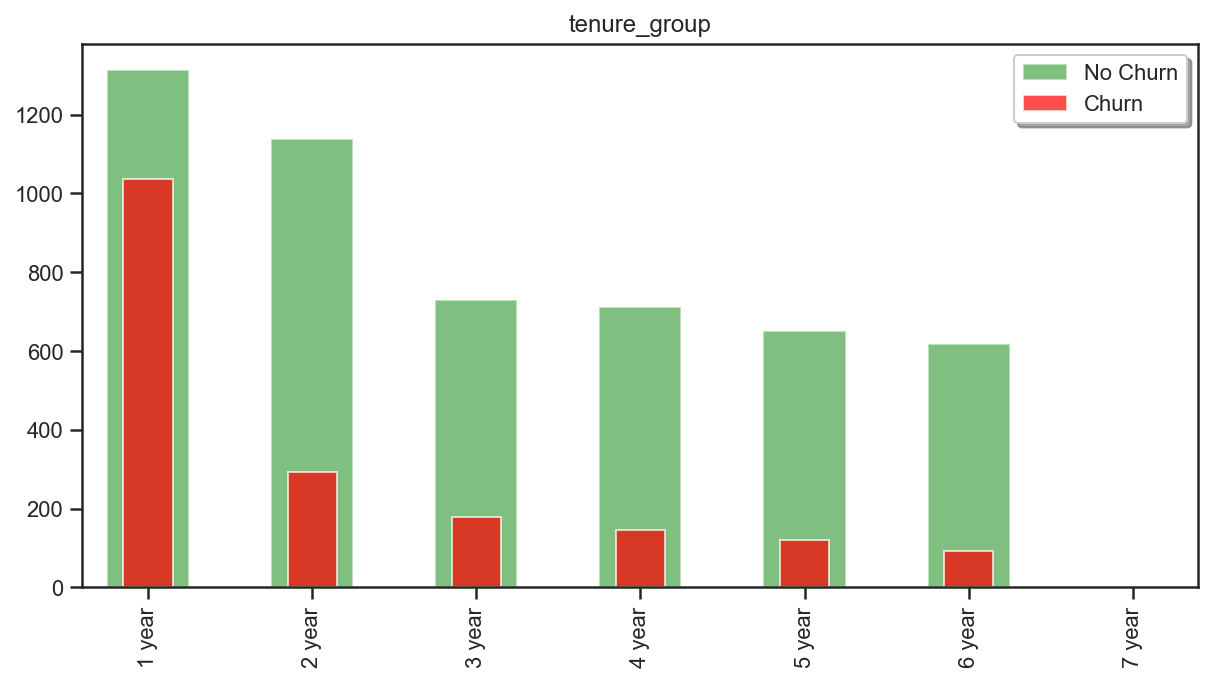

In [14]:
# new features tenure_group
plt.figure(figsize = [10,5])
df[df.Churn == "No"]['tenure_range'].value_counts().plot(kind = 'bar', color="green", alpha=0.5).set_title('tenure_group')
df[df.Churn == "Yes"]['tenure_range'].value_counts().plot(kind = 'bar', color="red", alpha=0.7, width=0.3)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   gender              7043 non-null   object  
 1   SeniorCitizen       7043 non-null   object  
 2   Partner             7043 non-null   object  
 3   Dependents          7043 non-null   object  
 4   tenure              7043 non-null   int64   
 5   PhoneService        7043 non-null   object  
 6   MultipleLines       7043 non-null   object  
 7   InternetService     7043 non-null   object  
 8   OnlineSecurity      7043 non-null   object  
 9   OnlineBackup        7043 non-null   object  
 10  DeviceProtection    7043 non-null   object  
 11  TechSupport         7043 non-null   object  
 12  StreamingTV         7043 non-null   object  
 13  StreamingMovies     7043 non-null   object  
 14  Contract            7043 non-null   object  
 15  PaperlessBilling    7043 non-null   ob

In [16]:
#Convertin the predictor variable in a binary numeric variable
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)

#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df)
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

# It is important to scale the variables in logistic regression so that all of them are within a range of 0 to 1
# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Feature Selection

In [17]:
import statsmodels.api as sm
X = sm.add_constant(X)  # need to add this to define the Intercept
model = sm.OLS(y,X).fit()
predict = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     94.19
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:06:54   Log-Likelihood:                -2976.4
No. Observations:                7043   AIC:                             6019.
Df Residuals:                    7010   BIC:                             6245.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                    3.669e+11      3e+11      1.222      0.222   -2.22e+11    9.56e+11
tenure                                     -0.5632      0.098     -5.770      0.000      -0.755      -0.372
MonthlyCharges                             -0.3179      0.440     -0.723      0.470      -1.180       0.544
TotalCharges                               -0.5658      0.060     -9.420      0.000      -0.684      -0.448
gender_Female                            3.099e+10   2.54e+10      1.222      0.222   -1.87e+10    8.07e+10
gender_Male                              3.099e+10   2.54e+10      1.222      0.222   -1.87e+10    8.07e+10
SeniorCitizen_No                        -4.468e+11   3.66e+11     -1.222      0.222   -1.16e+12     2.7e+11
SeniorCitizen_Yes                       -4.468e+11   3.66e+11     -1.222      0.222   -1.16e+12     2.7e+11
Partner_No                              -1.153e+10   9.44e+09     -1.222      0.222      -3e+10    6.97e+09
Partner_Yes                             -1.153e+10   9.44e+09     -1.222      0.222      -3e+10    6.97e+09
Dependents_No                           -2.258e+11   1.85e+11     -1.222      0.222   -5.88e+11    1.36e+11
Dependents_Yes                          -2.258e+11   1.85e+11     -1.222      0.222   -5.88e+11    1.36e+11
PhoneService_No                         -3.658e+11   2.99e+11     -1.222      0.222   -9.53e+11    2.21e+11
PhoneService_Yes                        -9.064e+11   7.42e+11     -1.222      0.222   -2.36e+12    5.48e+11
MultipleLines_No                         2.669e+11   2.18e+11      1.222      0.222   -1.61e+11    6.95e+11
MultipleLines_No phone service          -2.737e+11   2.24e+11     -1.222      0.222   -7.13e+11    1.65e+11
MultipleLines_Yes                        2.669e+11   2.18e+11      1.222      0.222   -1.61e+11    6.95e+11
InternetService_DSL                      1.743e+11   1.43e+11      1.222      0.222   -1.05e+11    4.54e+11
InternetService_Fiber optic              1.743e+11   1.43e+11      1.222      0.222   -1.05e+11    4.54e+11
InternetService_No                       1.128e+11   9.23e+10      1.222      0.222   -6.82e+10    2.94e+11
OnlineSecurity_No                        7.081e+10    5.8e+10      1.222      0.222   -4.28e+10    1.84e+11
OnlineSecurity_No internet service       1.075e+11    8.8e+10      1.222      0.222    -6.5e+10     2.8e+11
OnlineSecurity_Yes                       7.081e+10    5.8e+10      1.222      0.222   -4.28e+10    1.84e+11
OnlineBackup_No                           6.72e+10    5.5e+10      1.222      0.222   -4.06e+10    1.75e+11
OnlineBackup_No internet service         7.514e+10   6.15e+10      1.222      0.222   -4.54e+10    1.96e+11
OnlineBackup_Yes                          6.72e+10    5.5e+

In [18]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
std = StandardScaler()
std.fit(X.values)
X_scaled = std.transform(X.values)
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
print('LASSO best alpha: ', lasso_model.alpha_ )
list(zip(X.columns, lasso_model.coef_))

LASSO best alpha:  0.001


[('const', 0.0),
 ('tenure', -0.06424469282115851),
 ('MonthlyCharges', 0.0017295258081049614),
 ('TotalCharges', -0.13803345888977817),
 ('gender_Female', 0.0008382649501454376),
 ('gender_Male', -9.836421515917898e-18),
 ('SeniorCitizen_No', -0.016991578638115023),
 ('SeniorCitizen_Yes', 9.151655248848228e-16),
 ('Partner_No', -0.0),
 ('Partner_Yes', 0.0),
 ('Dependents_No', 0.006366711356467541),
 ('Dependents_Yes', -0.0),
 ('PhoneService_No', 0.0),
 ('PhoneService_Yes', -0.0),
 ('MultipleLines_No', -0.0183824324978232),
 ('MultipleLines_No phone service', 0.0),
 ('MultipleLines_Yes', 0.006356749511515205),
 ('InternetService_DSL', -0.0),
 ('InternetService_Fiber optic', 0.07543149745009785),
 ('InternetService_No', -0.004821503600065363),
 ('OnlineSecurity_No', 0.024320824503402186),
 ('OnlineSecurity_No internet service', -0.0013268520184396603),
 ('OnlineSecurity_Yes', -0.0),
 ('OnlineBackup_No', 0.00982333713256006),
 ('OnlineBackup_No internet service', -0.0007734851109138761),

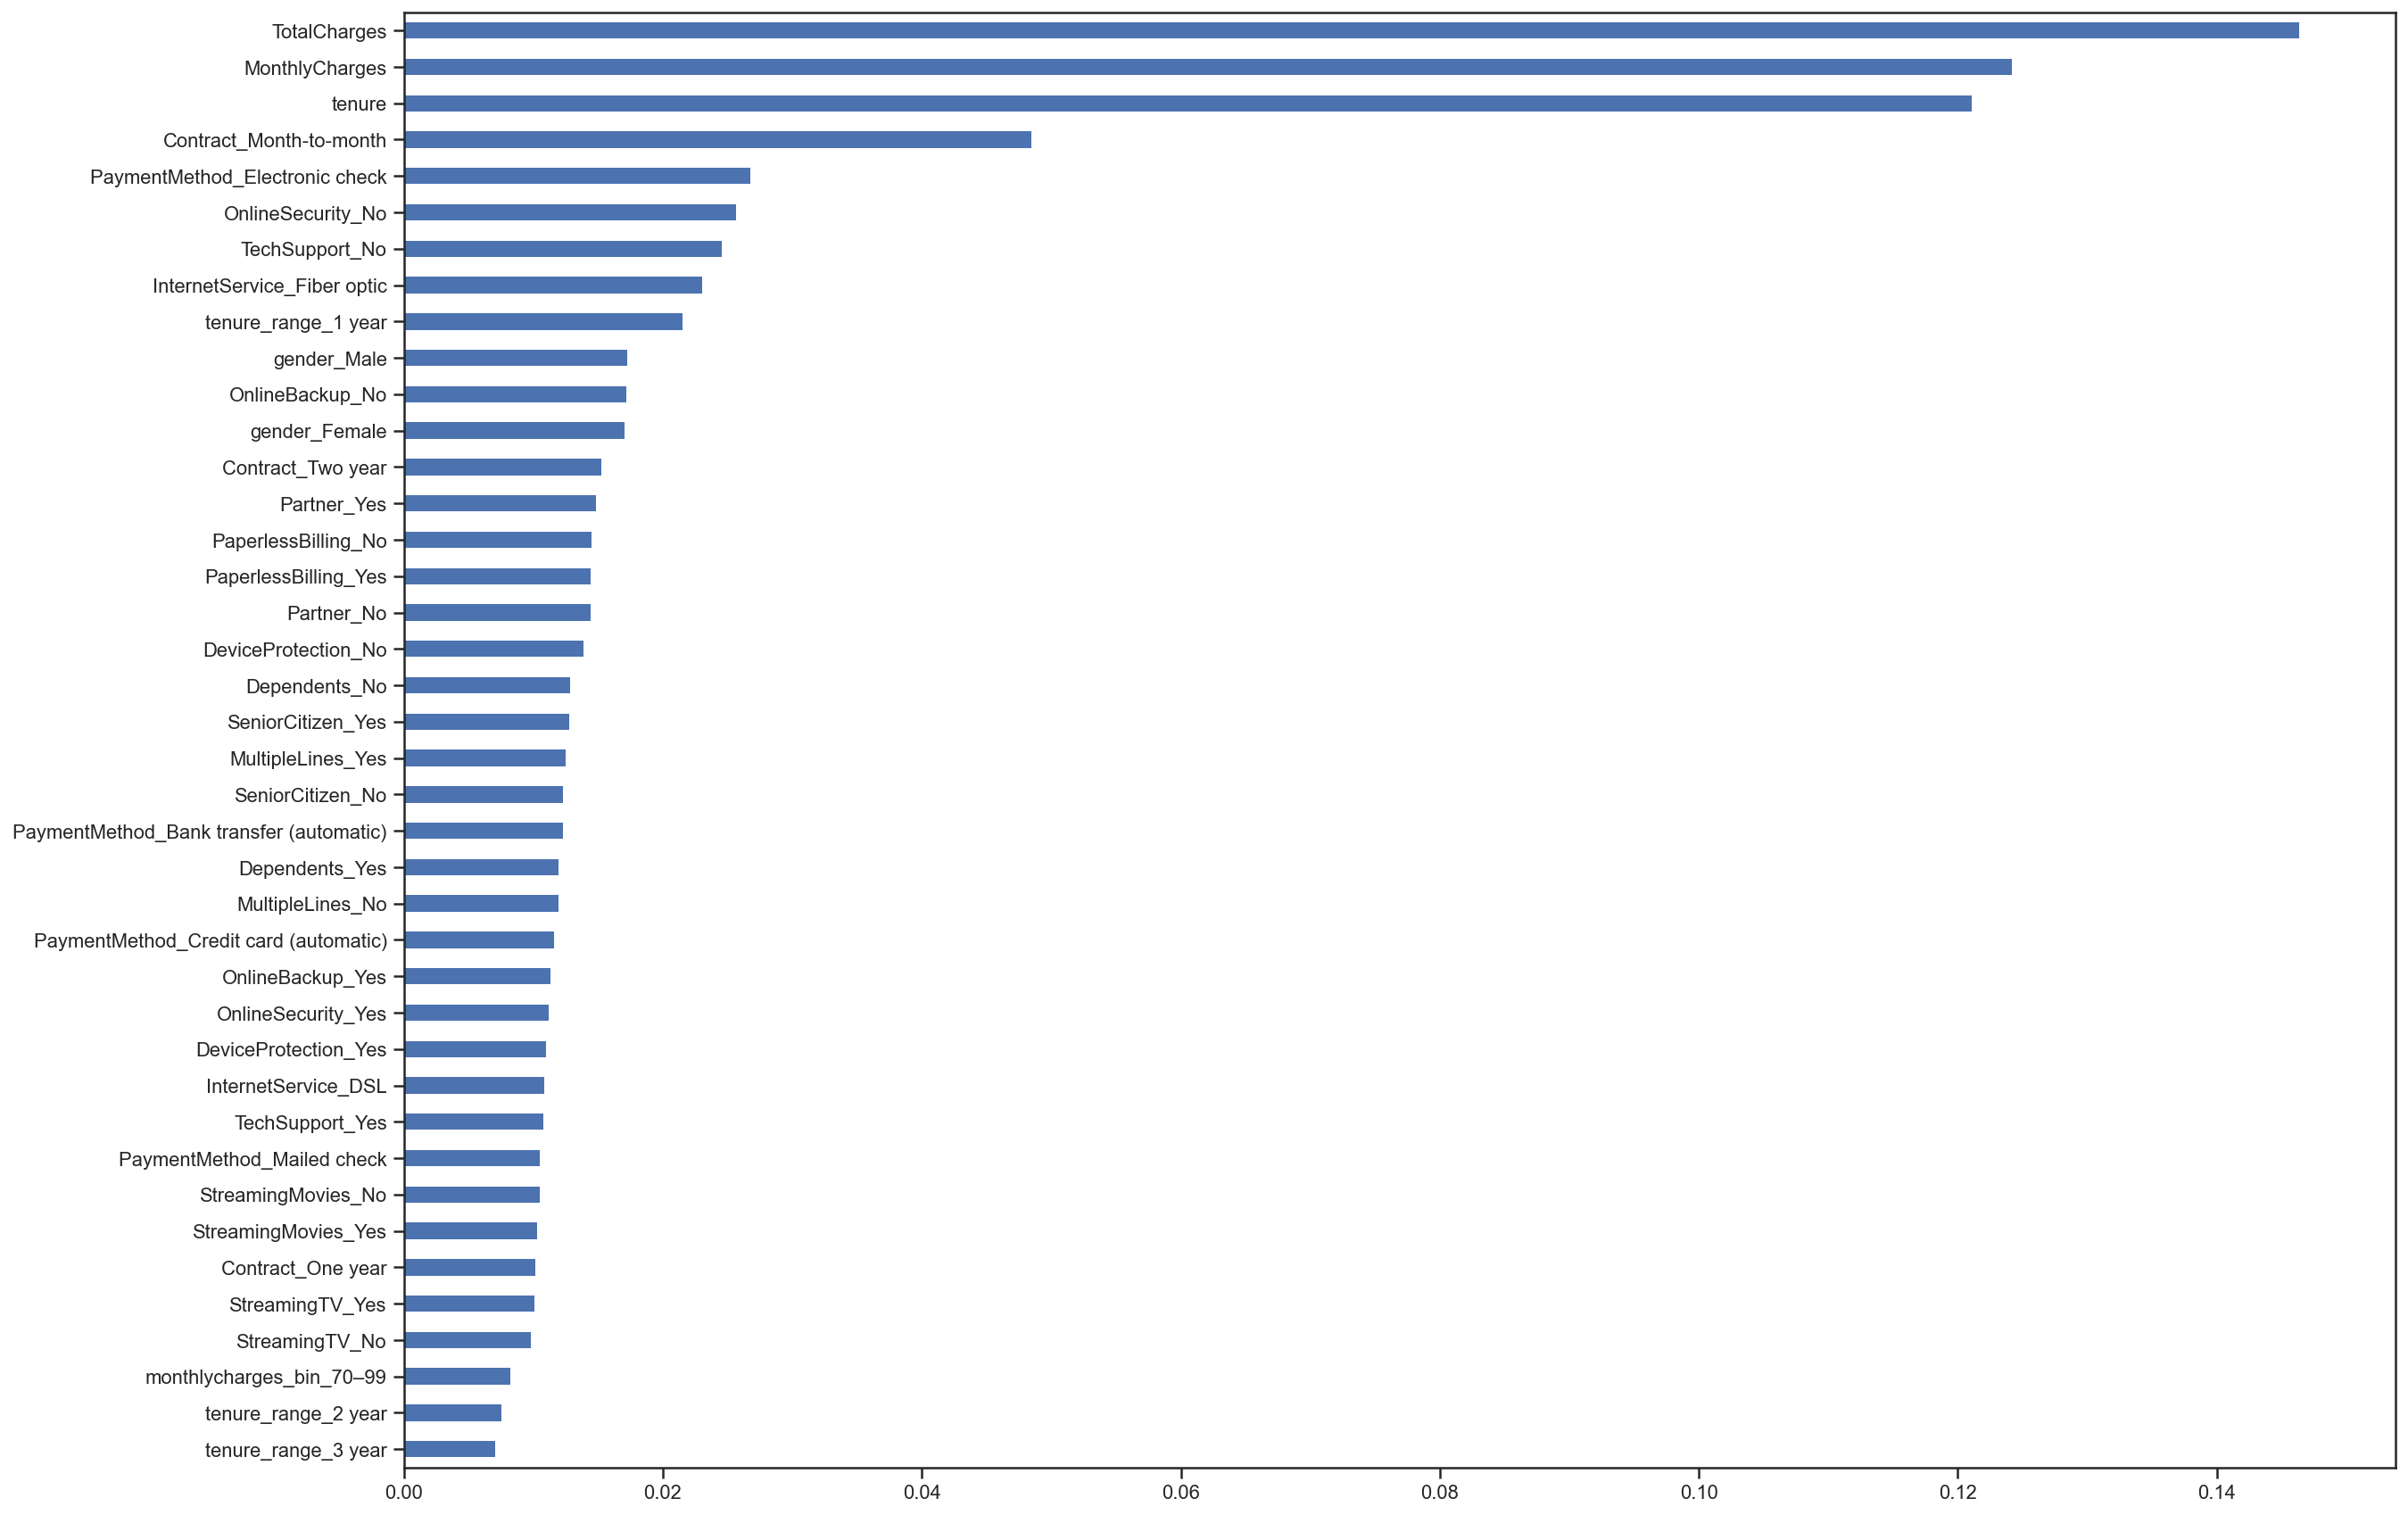

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, n_estimators=100)
model = rfc.fit(X, y)
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(40)  
   .plot(kind='barh', figsize=[20,15])
    .invert_yaxis())

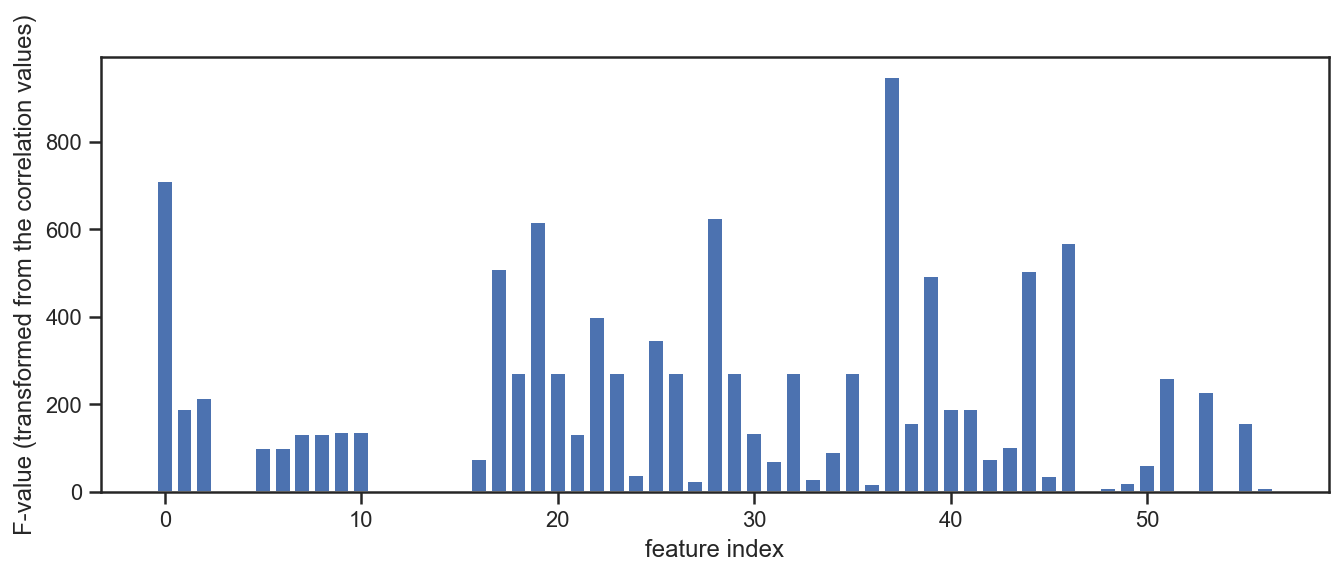

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

# Feature selection using the Correlation metric
f_selector = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# transform train input data
X_train_fs = f_selector.transform(X_train)
# transform test input data
X_test_fs = f_selector.transform(X_test)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("F-value (transformed from the correlation values)")
plt.show()

In [21]:
# what are scores for the features
for i in range(len(f_selector.scores_)):
	print('Feature %d: %f' % (i, f_selector.scores_[i]))

Feature 0: 709.952656
Feature 1: 189.824496
Feature 2: 213.813304
Feature 3: 0.016747
Feature 4: 0.016747
Feature 5: 100.450935
Feature 6: 100.450935
Feature 7: 131.293702
Feature 8: 131.293702
Feature 9: 135.180540
Feature 10: 135.180540
Feature 11: 0.006902
Feature 12: 0.006902
Feature 13: 4.016151
Feature 14: 0.006902
Feature 15: 4.329446
Feature 16: 73.477715
Feature 17: 509.154964
Feature 18: 272.255474
Feature 19: 615.693523
Feature 20: 272.255474
Feature 21: 130.934006
Feature 22: 399.216792
Feature 23: 272.255474
Feature 24: 38.696786
Feature 25: 346.779003
Feature 26: 272.255474
Feature 27: 24.010799
Feature 28: 626.068779
Feature 29: 272.255474
Feature 30: 134.745560
Feature 31: 69.147643
Feature 32: 272.255474
Feature 33: 28.123832
Feature 34: 91.526433
Feature 35: 272.255474
Feature 36: 16.592831
Feature 37: 946.814109
Feature 38: 155.732780
Feature 39: 492.524960
Feature 40: 189.588336
Feature 41: 189.588336
Feature 42: 75.474899
Feature 43: 100.966931
Feature 44: 505.0231

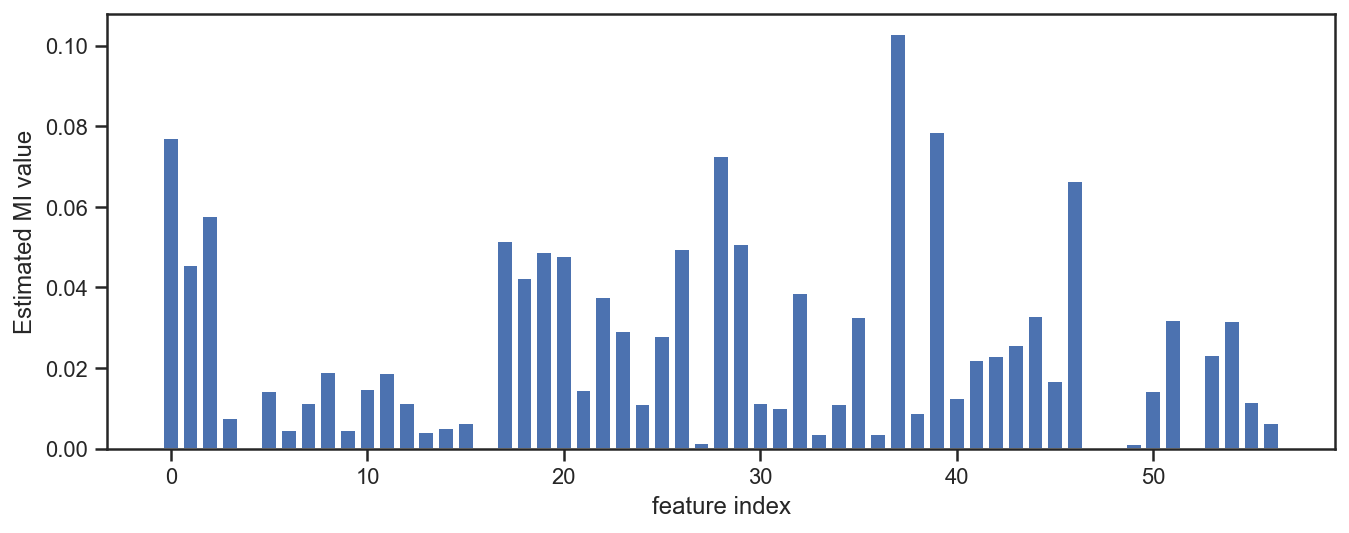

In [22]:
# feature selection using the Mutual Information metric
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# transform train input data
X_train_fs = f_selector.transform(X_train)
# transform test input data
X_test_fs = f_selector.transform(X_test)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("Estimated MI value")
plt.show()

In [23]:
# what are scores for the features
for i in range(len(f_selector.scores_)):
	print('Feature %d: %f' % (i, f_selector.scores_[i]))

Feature 0: 0.077040
Feature 1: 0.045631
Feature 2: 0.057811
Feature 3: 0.007537
Feature 4: 0.000000
Feature 5: 0.014365
Feature 6: 0.004494
Feature 7: 0.011346
Feature 8: 0.019112
Feature 9: 0.004568
Feature 10: 0.014725
Feature 11: 0.018854
Feature 12: 0.011418
Feature 13: 0.004114
Feature 14: 0.005230
Feature 15: 0.006376
Feature 16: 0.000000
Feature 17: 0.051633
Feature 18: 0.042239
Feature 19: 0.048862
Feature 20: 0.047770
Feature 21: 0.014613
Feature 22: 0.037570
Feature 23: 0.029301
Feature 24: 0.011020
Feature 25: 0.028074
Feature 26: 0.049578
Feature 27: 0.001464
Feature 28: 0.072626
Feature 29: 0.050685
Feature 30: 0.011391
Feature 31: 0.010067
Feature 32: 0.038737
Feature 33: 0.003662
Feature 34: 0.011066
Feature 35: 0.032602
Feature 36: 0.003613
Feature 37: 0.102814
Feature 38: 0.008880
Feature 39: 0.078585
Feature 40: 0.012643
Feature 41: 0.021912
Feature 42: 0.023042
Feature 43: 0.025636
Feature 44: 0.032843
Feature 45: 0.016719
Feature 46: 0.066357
Feature 47: 0.000000
Fe

# Model Selection

In [24]:
# Below is the function to print acuracy score, ROC curvey, ROC-AUC score and confusion matrix
def model_performance(model, model_name) : 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score_model4  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score_model4]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score_model4'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    
    #Cumulative gain
    pos = pd.get_dummies(y_test).to_numpy()
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=3, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                          'Precision - Recall curve',
                                          'Cumulative gains curve'
                                          ))
    
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    #fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model Performance Report - '+str(model_name) + '</b><br>',
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"),color = 'white')
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"),color = 'white')
    #fig["layout"]["xaxis6"].update(color = 'white')
    #fig["layout"]["yaxis6"].update(color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

In [25]:
# Cross val metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

In [26]:
%%time
lgbm_clf = lgbm.LGBMClassifier(n_estimators=1500, random_state = 42)

lgbm_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]

cross_val_metrics(lgbm_clf)

[accuracy] : 0.77197 (+/- 0.00869)
[precision] : 0.58478 (+/- 0.02171)
[recall] : 0.48796 (+/- 0.01000)
[f1] : 0.53189 (+/- 0.01343)
[roc_auc] : 0.80571 (+/- 0.00963)
Wall time: 46 s


In [27]:
model_performance(lgbm_clf, "Light gbm Model")

In [28]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier

adb_clf = AdaBoostClassifier()
adb_clf.fit(X_train,y_train)
y_pred = adb_clf.predict(X_test)
y_score = adb_clf.predict_proba(X_test)[:,1]

cross_val_metrics(adb_clf)


[accuracy] : 0.80463 (+/- 0.00687)
[precision] : 0.66235 (+/- 0.01784)
[recall] : 0.53879 (+/- 0.01617)
[f1] : 0.59406 (+/- 0.01402)
[roc_auc] : 0.84563 (+/- 0.01221)


In [29]:
model_performance(adb_clf, "AdaBoost Algorithm")

In [30]:
from sklearn.linear_model import LogisticRegression

lgr_clf = LogisticRegression()
lgr_clf.fit(X_train, y_train)
y_pred = lgr_clf.predict(X_test)
y_score = lgr_clf.predict_proba(X_test)[:,1]

cross_val_metrics(lgr_clf)


[accuracy] : 0.80477 (+/- 0.00756)
[precision] : 0.66667 (+/- 0.01777)
[recall] : 0.52863 (+/- 0.01635)
[f1] : 0.58964 (+/- 0.01656)
[roc_auc] : 0.84710 (+/- 0.01124)


In [31]:
model_performance(lgr_clf, "Logistic Regression Model")

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)
y_score = rf_clf.predict_proba(X_test)[:,1]

cross_val_metrics(rf_clf)

[accuracy] : 0.79895 (+/- 0.01131)
[precision] : 0.67353 (+/- 0.03345)
[recall] : 0.47191 (+/- 0.01669)
[f1] : 0.55485 (+/- 0.02164)
[roc_auc] : 0.84552 (+/- 0.01084)


In [33]:
model_performance(rf_clf, "Random Forest Classifier Model")

In [34]:
from xgboost import XGBClassifier
from sklearn import metrics
xgb_clf= XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_score = xgb_clf.predict_proba(X_test)[:,1]

metrics.accuracy_score(y_test, y_pred)


0.7770941788925698

In [35]:
cross_val_metrics(model)

[accuracy] : 0.78561 (+/- 0.01508)
[precision] : 0.62570 (+/- 0.03904)
[recall] : 0.48154 (+/- 0.02254)
[f1] : 0.54401 (+/- 0.02751)
[roc_auc] : 0.81916 (+/- 0.01330)


In [36]:
model_performance(xgb_clf, "XG Boost Model")